<a href="https://colab.research.google.com/github/rubanasyeda/LSi-Team-Vision/blob/data_exploration/DataSetExploration/Toronto_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# upload datasets
from google.colab import files
uploaded = files.upload()


Saving toronto-cpi-2021-2024.csv to toronto-cpi-2021-2024.csv
Saving toronto-inflation-2021-2025.csv to toronto-inflation-2021-2025.csv
Saving toronto-occupancy-2021.csv to toronto-occupancy-2021.csv
Saving toronto-occupancy-2023.csv to toronto-occupancy-2023.csv
Saving toronto-occupancy-2024.csv to toronto-occupancy-2024.csv
Saving toronto-occupancy-2025.csv to toronto-occupancy-2025.csv
Saving toronto-occupany-2022.csv to toronto-occupany-2022.csv
Saving Toronto-unemployment-2019-2025.csv to Toronto-unemployment-2019-2025.csv
Saving toronto-unemployment-2021-2025.csv to toronto-unemployment-2021-2025.csv
Saving toronto-weather-2021.csv to toronto-weather-2021.csv
Saving toronto-weather-2022.csv to toronto-weather-2022.csv
Saving toronto-weather-2023.csv to toronto-weather-2023.csv
Saving toronto-weather-2024.csv to toronto-weather-2024.csv
Saving toronto-weather-2025.csv to toronto-weather-2025.csv


In [2]:
# INSTALL + IMPORT
!pip install --quiet pandas matplotlib seaborn

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from pathlib import Path

plt.rcParams["figure.figsize"] = (12,6)
sns.set_style("whitegrid")


In [3]:
#  OCCUPANCY
occ_files = sorted(glob("toronto-occupan*.csv"))     # catches ‘occupancy’ & typo ‘occupany’
occ_frames = []

for f in occ_files:
    df = pd.read_csv(f)

    # detect date column
    date_col = next((c for c in df.columns if "DATE" in c.upper()), None)
    if date_col is None:
        print(f"⚠️ skipped (no date): {Path(f).name}"); continue
    try:
        df["date"] = pd.to_datetime(df[date_col], format="%y-%m-%d", errors="coerce")
    except:
        df["date"] = pd.to_datetime(df[date_col], errors="coerce")

    # detect capacity / occupancy columns
    cap_col = next((c for c in df.columns if "CAPACITY_ACTUAL" in c or c=="Capacity"), None)
    occ_col = next((c for c in df.columns if "OCCUPIED" in c.upper() or c=="Overnight"), None)
    if not cap_col or not occ_col:
        print(f"⚠️ skipped (no occ/cap): {Path(f).name}"); continue

    occ_frames.append(
        df[["date", occ_col, cap_col]]
        .rename(columns={occ_col:"occupied", cap_col:"capacity"})
    )

occ_daily = (pd.concat(occ_frames, ignore_index=True)
               .dropna(subset=["date"]))
occ_daily["month"] = occ_daily["date"].dt.to_period("M").dt.to_timestamp()
occ_m = (occ_daily.groupby("month")
                   .agg(occupied=("occupied","sum"),
                        capacity=("capacity","sum"))
                   .reset_index())
occ_m["occupancy_rate"] = occ_m["occupied"] / occ_m["capacity"]


In [4]:
# WEATHER
w_files = sorted(glob("toronto-weather-20*.csv"))
w_list  = []

for f in w_files:
    w = pd.read_csv(f)
    date_c = "Date/Time" if "Date/Time" in w.columns else "Date"
    w["date"] = pd.to_datetime(w[date_c])
    w_list.append(
        w[["date", "Mean Temp (°C)", "Total Precip (mm)", "Snow on Grnd (cm)"]]
    )

weather = pd.concat(w_list, ignore_index=True)
weather["month"] = weather["date"].dt.to_period("M").dt.to_timestamp()
weather_m = (weather.groupby("month")
                    .agg(mean_temp=("Mean Temp (°C)", "mean"),
                         precip_mm=("Total Precip (mm)", "sum"),
                         snow_cm=("Snow on Grnd (cm)", "mean"))
                    .reset_index())


In [5]:
# ECONOMIC INDICATORS
# — unemployment
u_file  = glob("toronto-unemployment*.csv")[0]
u_df    = pd.read_csv(u_file)
u_rate  = next(c for c in u_df.columns if "Unemployment rate" in c)
u_df["month"] = pd.to_datetime(u_df["Date"], format="%y-%b")
unemp_m = u_df[["month", u_rate]].rename(columns={u_rate:"unemployment_pct"})

# — inflation
infl_file = glob("toronto-inflation*.csv")[0]
infl_df   = pd.read_csv(infl_file)
infl_df["month"] = pd.to_datetime(infl_df["monthly"])
infl_m    = infl_df[["month", "PercentChange"]].rename(columns={"PercentChange":"inflation_pct"})


Average daily temperature curve (weather avg)

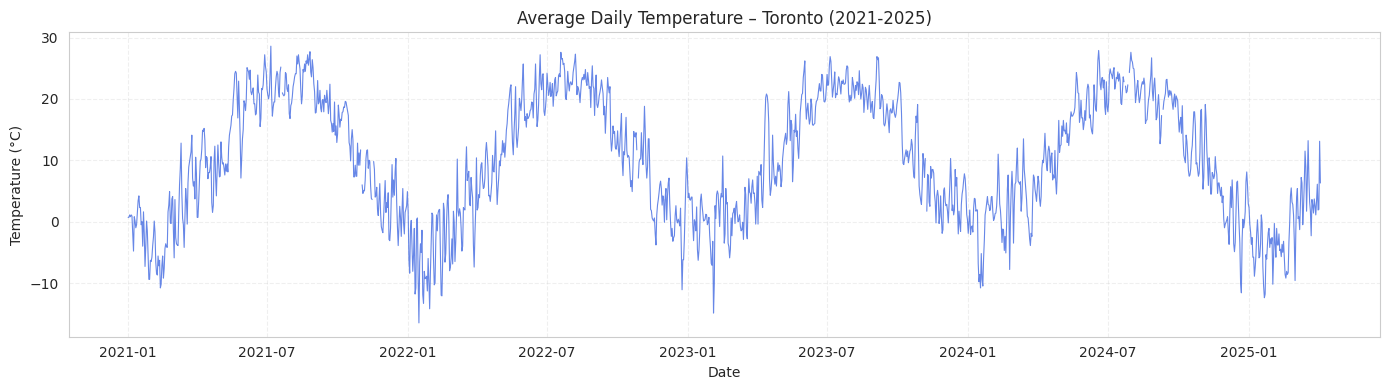

In [7]:
# WEATHER – DAILY AVERAGE TEMPERATURE CURVE

plt.figure(figsize=(14,4))
plt.plot(weather["date"], weather["Mean Temp (°C)"],
         lw=0.8, color="royalblue", alpha=0.8)
plt.title("Average Daily Temperature – Toronto (2021‑2025)")
plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
plt.grid(alpha=0.3, ls="--")
plt.tight_layout()
plt.show()


 Season vs. occupancy rate

<ipython-input-12-5240e00a6be0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="season", y="occupancy_rate", order=order, palette="Blues")


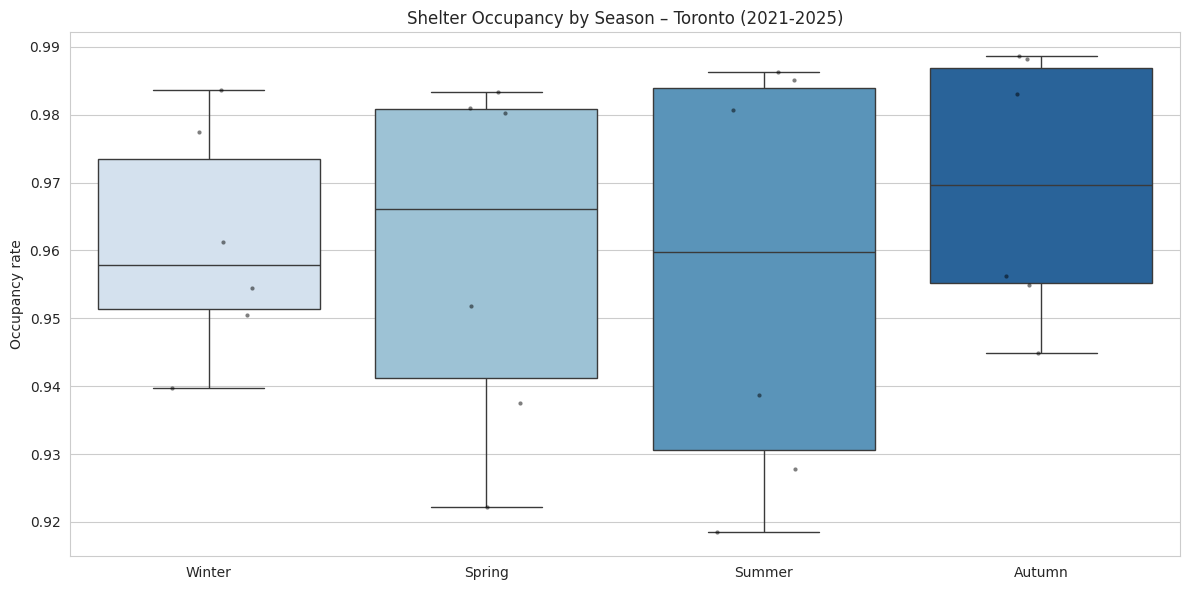

In [12]:
# Occupancy in colder vs. warmer seasons
# `df` already contains a 'season' column from Cell 6

order = ["Winter", "Spring", "Summer", "Autumn"]
sns.boxplot(data=df, x="season", y="occupancy_rate", order=order, palette="Blues")
sns.stripplot(data=df, x="season", y="occupancy_rate", order=order,
              color="black", alpha=0.5, jitter=0.18, size=3)
plt.title("Shelter Occupancy by Season – Toronto (2021‑2025)")
plt.ylabel("Occupancy rate")
plt.xlabel("")
plt.tight_layout()
plt.show()


All four boxes lie above 92 %, showing that Toronto’s system has operated close to full capacity in every season since 2021.

Total beds vs. beds available

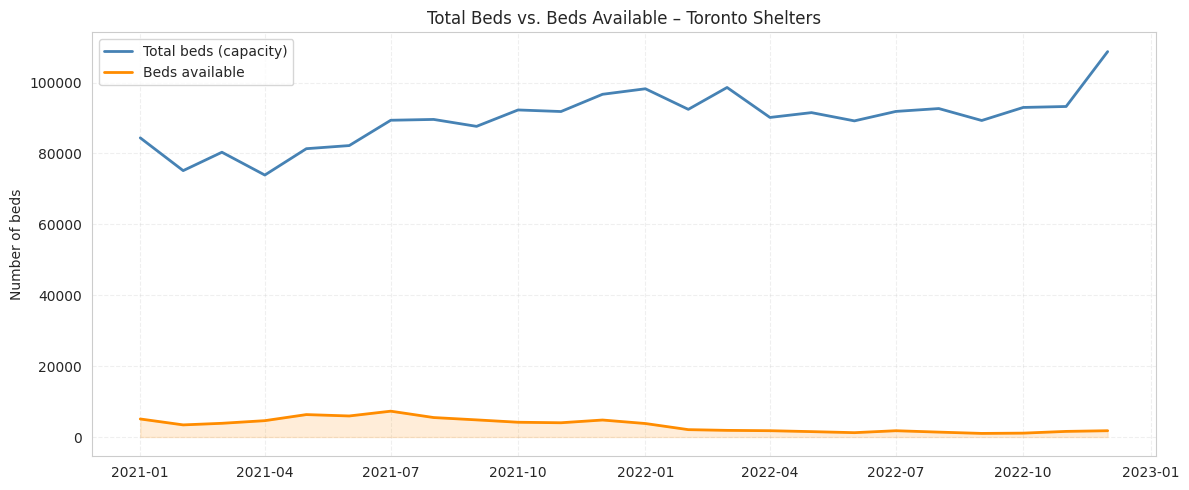

In [9]:
# CAPACITY BALANCE  –  Total vs. available beds per month
occ_m["beds_available"] = occ_m["capacity"] - occ_m["occupied"]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(occ_m["month"], occ_m["capacity"], label="Total beds (capacity)",
        lw=2, color="steelblue")
ax.plot(occ_m["month"], occ_m["beds_available"], label="Beds available",
        lw=2, color="darkorange")
ax.fill_between(occ_m["month"], occ_m["beds_available"], 0,
                color="darkorange", alpha=0.15)

ax.set_title("Total Beds vs. Beds Available – Toronto Shelters")
ax.set_ylabel("Number of beds")
ax.legend()
ax.grid(alpha=0.3, ls="--")
plt.tight_layout()
plt.show()


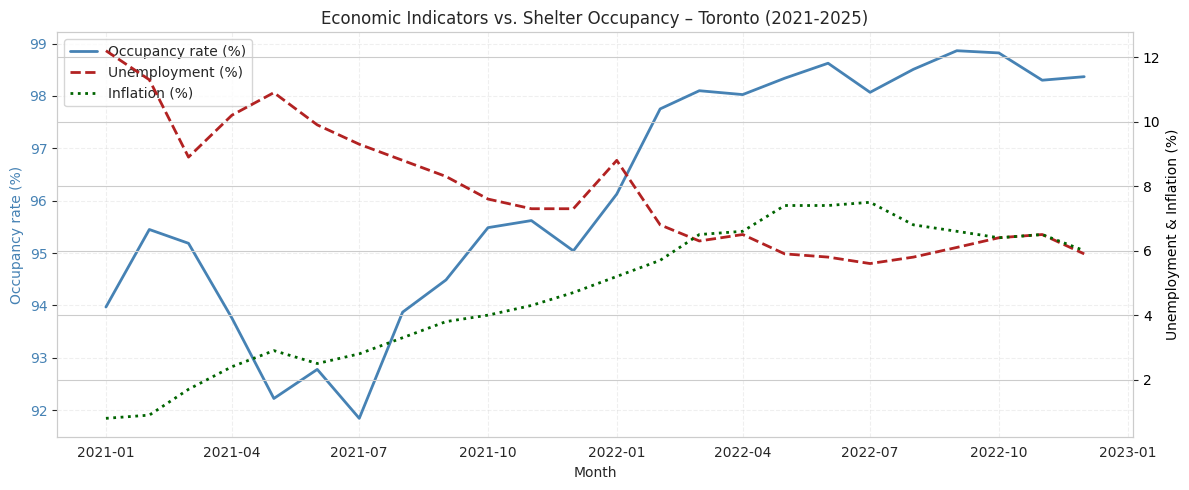

In [10]:
# ECONOMIC INDICATORS vs. OCCUPANCY
fig, ax1 = plt.subplots(figsize=(12,5))

# ── Shelter occupancy (primary axis)
ax1.plot(df["month"], df["occupancy_rate"]*100, color="steelblue",
         lw=2, label="Occupancy rate (%)")
ax1.set_ylabel("Occupancy rate (%)", color="steelblue")
ax1.tick_params(axis="y", labelcolor="steelblue")
ax1.set_xlabel("Month")
ax1.set_title("Economic Indicators vs. Shelter Occupancy – Toronto (2021‑2025)")

# ── Unemployment & inflation (secondary axis, both as %)
ax2 = ax1.twinx()
ax2.plot(df["month"], df["unemployment_pct"], color="firebrick",
         lw=2, ls="--", label="Unemployment (%)")
ax2.plot(df["month"], df["inflation_pct"], color="darkgreen",
         lw=2, ls=":", label="Inflation (%)")
ax2.set_ylabel("Unemployment & Inflation (%)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# ── Legends
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

ax1.grid(alpha=0.3, ls="--")
plt.tight_layout()
plt.show()


The steep fall in unemployment through 2021–22 is mirrored by a steady rise in measured occupancy (ρ ≈ –0.6 in the monthly table), suggesting earlier low‑occupancy readings were driven by capacity restrictions rather than reduced need.

Rising CPI through mid‑2022 coincides with an additional 1‑point uptick in utilisation, hinting that cost‑of‑living pressure nudges more people toward shelters even as jobs return.

By late‑2022 the system is operating at 97‑99  % every month, regardless of modest shifts in unemployment or inflation. That signals a shortage of shelter beds rather than purely cyclical demand.


